Packages

In [146]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.optimize import least_squares
from scipy.spatial import cKDTree
from scipy.spatial import KDTree
from numpy.polynomial.polynomial import Polynomial

Initialization

In [147]:
# File imports
# target_file = r"C:\Users\eirik\OneDrive - NTNU\Semester 9\Prosjektoppgave\o3d_map\bay_template_data\data_0.npy"  # Path to the source .npy file
# source_file = r"C:\Users\eirik\OneDrive - NTNU\Semester 10\code\pcmf\maps\mr_2710_complete.npy"  # Path to the source .npy file
source_file = r"C:\Users\eirik\OneDrive - NTNU\Semester 10\code\pcmf\maps\mr_2710_complete.npy"  # Path to the source .npy file
target_file = r"C:\Users\eirik\OneDrive - NTNU\Semester 9\Prosjektoppgave\o3d_map\bay_evaluation_data\data_0.npy"  # Path to the target .npy file
vessel_path_file = r"C:\Users\eirik\OneDrive - NTNU\Semester 10\code\pcmf\maps\mr_2710_complete_positions.npy"

# Initial transformation
rotation_angle = np.radians(100) # SET TARGET ROTATION ANGLE
xy_translation = [10, 10] # SET TARGET TRANSLATION

# ICP parameters
rmse_threshold = 0.01
rotation_increment = np.radians(10)
max_rotation_increments = 2*np.pi/rotation_increment # adds up to one full rotation

time_plot_open = 10 # Seconds

Transformation functions

In [148]:
def apply_transformation(points, translation=np.array([0, 0]), rotation_angle=0):
    # Define a 2D rotation matrix
    c, s = np.cos(rotation_angle), np.sin(rotation_angle)
    R = np.array([[c, -s], [s, c]])
    
    # Apply rotation and then translation
    transformed_points = np.dot(points, R) + translation    
    
    return transformed_points

def get_rotation_translation_from_matrix(matrix):
    # Assuming matrix is a 4x4 homogeneous transformation matrix
    rotation_matrix = matrix[:3, :3]
    translation_vector = matrix[:3, 3]

    # Calculate the Euler angles from the rotation matrix
    sy = np.sqrt(rotation_matrix[0,0] * rotation_matrix[0,0] +  rotation_matrix[1,0] * rotation_matrix[1,0])
    singular = sy < 1e-6
    if not singular:
        x = np.arctan2(rotation_matrix[2,1], rotation_matrix[2,2])
        y = np.arctan2(-rotation_matrix[2,0], sy)
        z = np.arctan2(rotation_matrix[1,0], rotation_matrix[0,0])
    else:
        x = np.arctan2(-rotation_matrix[1,2], rotation_matrix[1,1])
        y = np.arctan2(-rotation_matrix[2,0], sy)
        z = 0

    euler_angles = np.array([x, y, z])
    return euler_angles, translation_vector

def ssa(angle_deg):
    if abs(angle_deg) > 180:
        return abs(abs(angle_deg) - 360)
    return abs(angle_deg)

# def dbscan_filtering(points, eps_threshold=0.5, min_points=10):
#     # Apply DBSCAN clustering, min_samples=10 signifies that a cluster must have at least 10 points
#     clustering = DBSCAN(eps=eps_threshold, min_samples=min_points).fit(points)
#     labels = clustering.labels_

#     # Filter out noise (label == -1)
#     filtered_points = points[labels != -1]
#     return filtered_points



Load points

In [149]:
# Load points from .npy files
source_points = np.load(source_file)
target_points = np.load(target_file)
path_points = np.load(vessel_path_file)

# Apply initial transformation
target_points = apply_transformation(target_points, translation=np.array(xy_translation), rotation_angle=rotation_angle)

Point cloud leveling

Euler angles: [0.22 1.3  0.  ] degrees


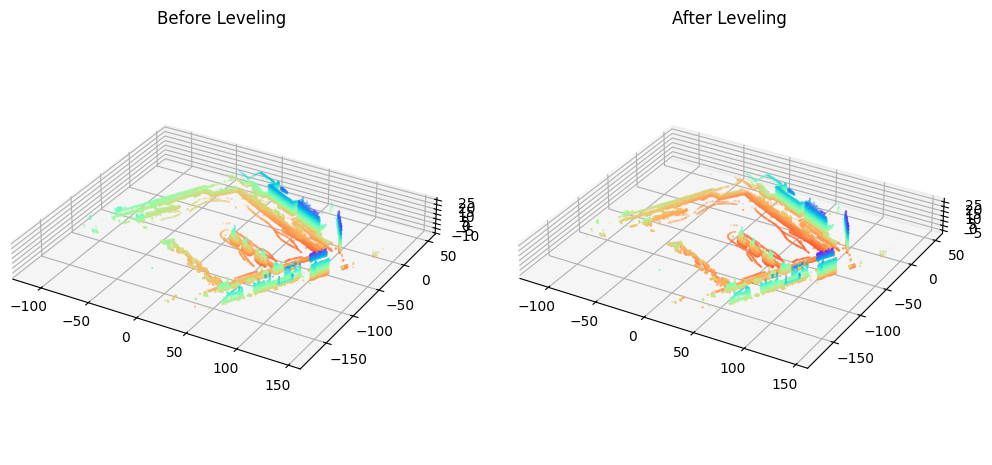

In [150]:
# Load points from .npy files
source_points = np.load(source_file)
target_points = np.load(target_file)
path_points = np.load(vessel_path_file)

def level_point_cloud(slam_point_cloud, path_point_cloud, num_path_points=100):
    # Select 100 evenly spaced points from the path point cloud
    step = len(path_point_cloud) // num_path_points
    sampled_path_points = path_point_cloud[::step][:num_path_points]

    # Fit a plane to the sampled path points
    def plane_residuals(params, X, Y, Z):
        a, b, c, d = params
        return a * X + b * Y + c * Z + d

    X, Y, Z = sampled_path_points[:, 0], sampled_path_points[:, 1], sampled_path_points[:, 2]
    plane_coeffs = least_squares(plane_residuals, [1, 0, 0, 0], args=(X, Y, Z)).x

    # Calculate rotation matrix to align the plane with the horizontal plane
    normal = plane_coeffs[:3]
    target = np.array([0, 0, 1])  # Z-axis
    a, b = (normal / np.linalg.norm(normal)).reshape(3), target.reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    
    # calculate euler angles from rotation matrix without using exisiting functions
    euler_angles = np.zeros(3)
    euler_angles[0] = np.arctan2(rotation_matrix[2,1], rotation_matrix[2,2])
    euler_angles[1] = np.arctan2(-rotation_matrix[2,0], np.sqrt(rotation_matrix[2,1]**2 + rotation_matrix[2,2]**2))
    euler_angles[2] = np.arctan2(rotation_matrix[1,0], rotation_matrix[0,0])
    euler_angles = np.degrees(euler_angles)
    euler_angles = np.array([ssa(euler_angles[0]), ssa(euler_angles[1]), ssa(euler_angles[2])])
    euler_angles = euler_angles.round(decimals=2)
    
    # print euler rotation angles
    print("Euler angles:", euler_angles, "degrees")

    # Apply rotation to the SLAM point cloud
    return slam_point_cloud.dot(rotation_matrix.T)

# plot the point cloud before leveling
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(source_points[:, 0], source_points[:, 1], source_points[:, 2], c=source_points[:, 2], cmap='rainbow_r', s=0.1)
ax1.set_title('Before Leveling')
ax1.set_aspect('equal')

# level the point cloud
source_points = level_point_cloud(source_points, path_points)

# plot the point cloud after leveling
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(source_points[:, 0], source_points[:, 1], source_points[:, 2], c=source_points[:, 2], cmap='rainbow_r', s=0.1)
ax2.set_title('After Leveling')
ax2.set_aspect('equal')

plt.show()

Filtering

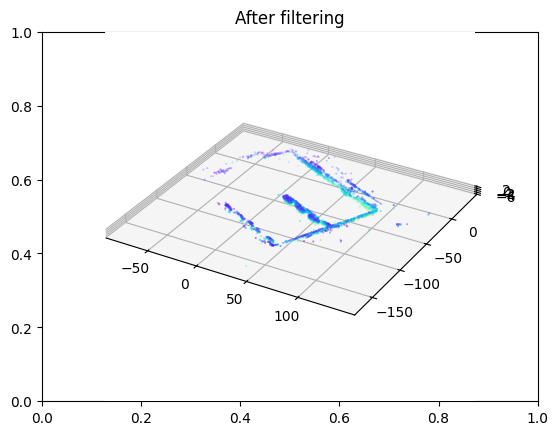

Number of points before filtering:  31529 
Number of points after filtering:  3342


In [151]:
def dbscan_filtering(points, eps_threshold, min_points, size_threshold):
    # Perform DBSCAN clustering
    clustering = DBSCAN(eps=eps_threshold, min_samples=min_points).fit(points)
    labels = np.unique(clustering.labels_)
    filtered_points = []
    
    # Loop over each cluster
    for label in labels:
        # Skip the noise points
        if label == -1:
            continue

        # Get the points in this cluster
        cluster_points = points[clustering.labels_ == label]

        # Calculate the dimensions of this cluster
        dimensions = cluster_points.max(axis=0) - cluster_points.min(axis=0)

        # If the cluster exceeds the size threshold in all dimensions, add it to the filtered points
        if np.all(dimensions > size_threshold):
            filtered_points.extend(cluster_points)

    return np.array(filtered_points)

def z_filtering(points, z_min, z_max):
    # Filter out points with z-values outside the given range
    return points[(points[:, 2] > z_min) & (points[:, 2] < z_max)]

def remove_outliers(point_cloud, k, std_ratio):
    # k, neighbours to consider: higher k -> more points removed
    # std_ratio, number of standard deviations to consider: higher std_ratio -> more points removed
    tree = cKDTree(point_cloud)
    distances, indices = tree.query(point_cloud, k=k)
    mean_distances = np.mean(distances, axis=1)
    std_distances = np.std(distances, axis=1)
    filtered_points = point_cloud[mean_distances > std_ratio * std_distances]
    return filtered_points

# Store size of source point cloud before filtering
source_len = len(source_points)

# Z-filter out points with z-values outside the given range
source_points2 = z_filtering(source_points, z_min=-10, z_max=2)
source_points2 = remove_outliers(source_points2, k=20, std_ratio=2.8)

# after filtering
fig = plt.figure()
plt.title("After filtering")
ax = fig.add_subplot(111, projection='3d')
ax.scatter(source_points2[:, 0], source_points2[:, 1], source_points2[:, 2], c=source_points2[:, 2], cmap='rainbow_r', s=0.1)
ax.set_aspect('equal')
plt.show()

# number of points before and after downsampling
print("Number of points before filtering: ", source_len, "\nNumber of points after filtering: ", len(source_points2))



Main execution

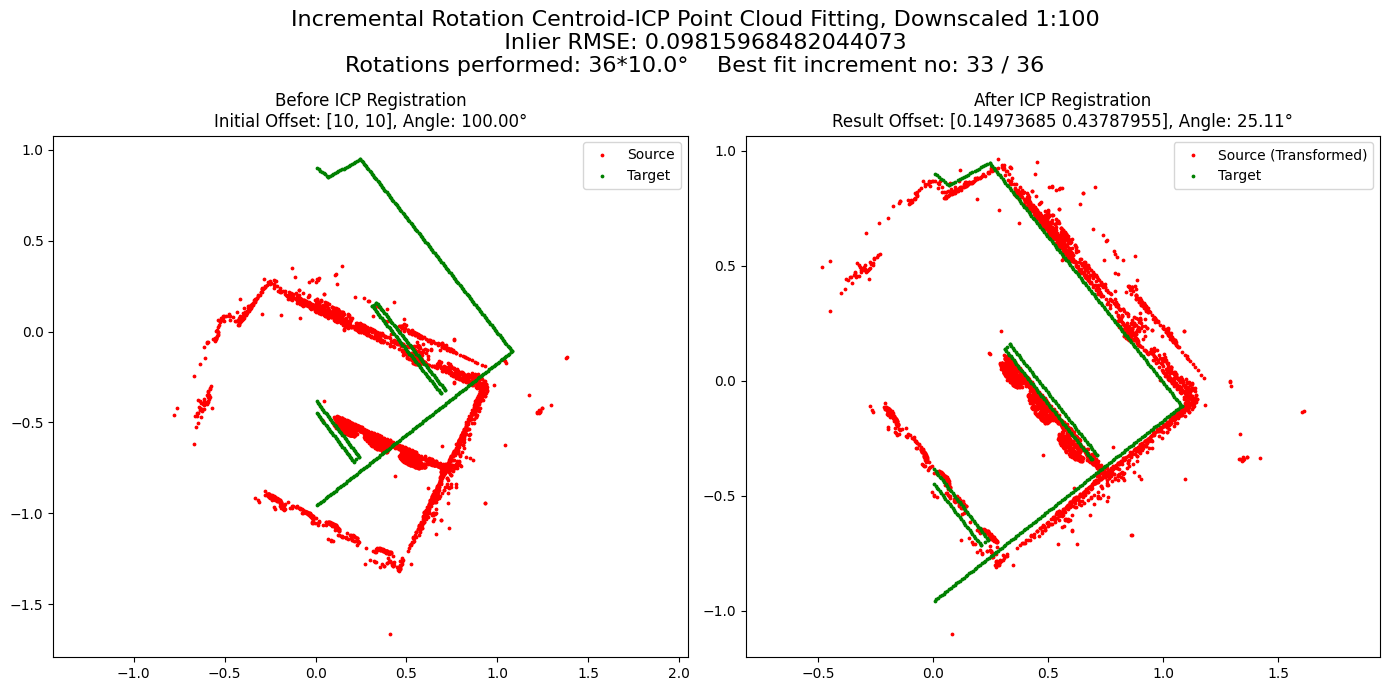

Best transformation:
[[ 0.99635548 -0.08529802  0.          0.14973685]
 [ 0.08529802  0.99635548  0.          0.43787955]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


In [152]:
def main():
    
    # convert source to 2D
    source_points_2d = source_points2[:, :2] * 1/100 # downscale to meters

    # Convert to Open3D point cloud objects
    source = o3d.geometry.PointCloud()
    source.points = o3d.utility.Vector3dVector(np.hstack((source_points_2d, np.zeros((source_points_2d.shape[0], 1)))))
    source2 = source # keep original source cloud for final visualization
    target = o3d.geometry.PointCloud()
    target.points = o3d.utility.Vector3dVector(np.hstack((target_points, np.zeros((target_points.shape[0], 1)))))

    # Calculate centroids of source and target
    source_centroid = np.mean(np.asarray(source.points), axis=0)
    target_centroid = np.mean(np.asarray(target.points), axis=0)
    translation_to_target_centroid = target_centroid - source_centroid

    # Initialize the transformation matrix
    trans_init = np.identity(4)
    trans_init[0:3, 3] = translation_to_target_centroid[0:3]

    # Visualize initial point clouds using plt
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    plt.subplots_adjust(top=0.75)

    initial_offset_text = f'Initial Offset: {xy_translation}, Angle: {ssa(np.degrees(rotation_angle)):.2f}°'
    axs[0].set_title('Before ICP Registration\n' + initial_offset_text)
    axs[0].scatter(np.asarray(source.points)[:, 0], np.asarray(source.points)[:, 1], c='r', label='Source', s=3)
    axs[0].scatter(np.asarray(target.points)[:, 0], np.asarray(target.points)[:, 1], c='g', label='Target', s=3)
    axs[0].legend()
    axs[0].axis('equal')
    
    # Initialize the RMSE threshold and rotation increment
    best_icp_result = None
    best_rmse = float('inf')
    increment_count = 0

    # Run the ICP registration until the RMSE is below the threshold or the source has been fully rotated
    while True and increment_count < max_rotation_increments:
        reg_p2p = o3d.pipelines.registration.registration_icp(
            source, target, 0.99, trans_init,
            o3d.pipelines.registration.TransformationEstimationPointToPoint()
        )

        # Update the best ICP result if the current RMSE is lower than the previous best
        if reg_p2p.inlier_rmse < best_rmse:
            best_icp_result = reg_p2p
            best_rmse = reg_p2p.inlier_rmse
            best_fit_increment = increment_count

        # Check if RMSE is below the threshold
        if best_rmse <= rmse_threshold and not best_rmse == 0:
            break

        # Rotate the source point cloud by the increment
        source.rotate(o3d.geometry.get_rotation_matrix_from_xyz((0, 0, rotation_increment)), center=source_centroid)
        # Update the initial transformation to be used as an initial guess for the next iteration
        trans_init[:3, :3] = o3d.geometry.get_rotation_matrix_from_xyz((0, 0, rotation_increment))
        increment_count += 1

    # Extract translation and rotation from the transformation matrix
    transformation = best_icp_result.transformation
    translation_result = transformation[0:3, 3]
    rotation_result = transformation[0:3, 0:3]
    rotation_angle_result = np.arccos((np.trace(rotation_result) - 1) / 2)  + best_fit_increment * rotation_increment
    transformation_text = f'Result Offset: {translation_result[:2]}, Angle: {ssa(np.degrees(rotation_angle_result)):.2f}°'
    
    # After finding the best ICP transformation, apply it to the source. First incremental, then icp transform
    source2.rotate(o3d.geometry.get_rotation_matrix_from_xyz((0, 0, rotation_increment*best_fit_increment)), center=source_centroid)
    source2.transform(best_icp_result.transformation)

    # Visualize the point clouds after registration using plt
    axs[1].set_title('After ICP Registration\n' + transformation_text)
    axs[1].scatter(np.asarray(source2.points)[:, 0], np.asarray(source2.points)[:, 1], c='r', label='Source (Transformed)', s=3)
    axs[1].scatter(np.asarray(target.points)[:, 0], np.asarray(target.points)[:, 1], c='g', label='Target', s=3)
    axs[1].legend()
    axs[1].axis('equal')
   
    # Save and show the plots
    plot_stats = "   Inlier RMSE: " + str(reg_p2p.inlier_rmse)  + "\nRotations performed: " + str(increment_count) + "*" + str(np.degrees(rotation_increment)) + "°" + "    Best fit increment no: " + str(best_fit_increment) + " / " + str(increment_count) 
    fig.suptitle('Incremental Rotation Centroid-ICP Point Cloud Fitting, Downscaled 1:100\n' + plot_stats, fontsize=16)
    # plt.savefig("o3d_npy_centroid_icp.png")
    plt.tight_layout()
    plt.show()

    print("Best transformation:")
    print(best_icp_result.transformation)        
    
if __name__ == "__main__":
    main()